In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def read_gene_expression(file_path):
    """
    Read gene expression data with RNA-Seq RSEM normalized values
    
    Parameters:
    file_path (str): Path to gene expression file
    
    Returns:
    pandas.DataFrame: DataFrame with patient_id, sample_id and gene expression values
    """
    # Read the tab-separated file
    df = pd.read_csv(file_path, sep='\t')
    print(f"Gene expression data loaded: {df.shape[0]} samples, {df.shape[1]-2} genes")
    return df

def read_somatic_mutations(file_path):
    """
    Read somatic mutations data in MAF format
    
    Parameters:
    file_path (str): Path to mutation annotation file
    
    Returns:
    pandas.DataFrame: DataFrame with mutation information
    """
    # Read the tab-separated MAF file
    df = pd.read_csv(file_path, sep='\t')
    print(f"Somatic mutations data loaded: {df.shape[0]} mutations")
    return df

def read_patient_metadata(file_path):
    """
    Read patient clinical and pathological metadata
    
    Parameters:
    file_path (str): Path to patient metadata file
    
    Returns:
    pandas.DataFrame: DataFrame with patient clinical information
    """
    # Read the tab-separated metadata file
    df = pd.read_csv(file_path, sep='\t')
    print(f"Patient metadata loaded: {df.shape[0]} patients")
    return df

def explore_data(gene_expr, somatic_mut, patient_meta):
    """
    Basic exploration of the three datasets
    """
    # Explore patient metadata
    print("\nPatient demographics:")
    print(f"Gender distribution:\n{patient_meta['gender'].value_counts()}")
    print(f"Age statistics:\n{patient_meta['age_at_initial_pathologic_diagnosis'].describe()}")
    
    # Analyze survival data
    print("\nSurvival statistics:")
    print(f"Overall survival events: {patient_meta['OS'].sum()} deaths out of {patient_meta['OS'].count()} patients")
    
    # Look at mutations per patient
    if 'patient_id' in somatic_mut.columns:
        mutations_per_patient = somatic_mut['patient_id'].value_counts()
        print(f"\nMutations per patient statistics:")
        print(mutations_per_patient.describe())
    
    # For gene expression, we could look at the most variable genes
    if gene_expr is not None and gene_expr.shape[1] > 2:
        print("\nGene expression statistics:")
        gene_columns = gene_expr.columns[2:]  # Skipping patient_id and sample_id
        gene_variance = gene_expr[gene_columns].var().sort_values(ascending=False)
        print(f"Top 5 most variable genes:\n{gene_variance.head(5)}")

In [3]:
# 导入所需的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 假设你的文件路径
gene_expression_path = os.path.join(os.getcwd(), 'Team_4_STAD', 'TCGA.STAD.expression.txt')
somatic_mutations_path = os.path.join(os.getcwd(), 'Team_4_STAD', 'TCGA.STAD.mutations.txt')
metadata_path = os.path.join(os.getcwd(), 'Team_4_STAD', 'TCGA.STAD.metadata.txt')

# 读取三个数据集
gene_expr = read_gene_expression(gene_expression_path)
somatic_mut = read_somatic_mutations(somatic_mutations_path)
patient_meta = read_patient_metadata(metadata_path)

# 探索数据
explore_data(gene_expr, somatic_mut, patient_meta)

Gene expression data loaded: 447 samples, 20531 genes
Somatic mutations data loaded: 234941 mutations
Patient metadata loaded: 415 patients

Patient demographics:
Gender distribution:
gender
MALE      265
FEMALE    150
Name: count, dtype: int64
Age statistics:
count    410.000000
mean      65.787805
std       10.746983
min       30.000000
25%       58.000000
50%       67.000000
75%       73.000000
max       90.000000
Name: age_at_initial_pathologic_diagnosis, dtype: float64

Survival statistics:
Overall survival events: 160.0 deaths out of 415 patients

Mutations per patient statistics:
count      415.000000
mean       566.122892
std       1163.583650
min          1.000000
25%        108.000000
50%        173.000000
75%        383.000000
max      14110.000000
Name: count, dtype: float64

Gene expression statistics:
Top 5 most variable genes:
ADAM6|8755     1.094407e+11
KRT4|3851      4.444138e+10
KRT13|3860     3.805078e+10
PGC|5225       2.561217e+10
PGA3|643834    1.474750e+10
dtype:

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
from scipy import stats
from sklearn.decomposition import PCA

def perform_umap_analysis(gene_expr, patient_meta, n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, pca=False):
    """
    Perform UMAP dimensionality reduction on gene expression data and analyze results

    Parameters:
    -----------
    gene_expr : pandas.DataFrame
        Gene expression data with patient_id, sample_id and gene expression values
    patient_meta : pandas.DataFrame
        Patient metadata with clinical information
    n_neighbors : int, default=15
        Number of neighbors to consider for local neighborhood in UMAP
    min_dist : float, default=0.1
        Minimum distance between points in the low-dimensional representation
    n_components : int, default=2
        Number of dimensions to reduce to
    random_state : int, default=42
        Random seed for reproducibility

    Returns:
    --------
    pandas.DataFrame
        DataFrame with UMAP coordinates and patient metadata
    """
    # Extract gene expression matrix (remove patient_id and sample_id columns)
    gene_columns = gene_expr.columns[2:]
    X = gene_expr[gene_columns].values

    if pca:
        pca = PCA(n_components=100)  # 先降到50维
        X_pca = pca.fit_transform(X)
        X_scaled = StandardScaler().fit_transform(X_pca)
    else:
        # Standardize the data (important for UMAP)
        X_scaled = StandardScaler().fit_transform(X)

    # Create patient ID to index mapping for later merging
    patient_ids = gene_expr['patient_id'].values

    # Perform UMAP dimensionality reduction
    print(f"Performing UMAP with n_neighbors={n_neighbors}, min_dist={min_dist}...")
    umap_model = UMAP(n_neighbors=n_neighbors,
                    min_dist=min_dist,
                    n_components=n_components,
                    random_state=random_state,
                    metric='cosine',
                    )
    umap_result = umap_model.fit_transform(X_scaled)

    # Create a DataFrame with UMAP results
    umap_df = pd.DataFrame(data=umap_result,
                        columns=[f'UMAP{i+1}' for i in range(n_components)])
    umap_df['patient_id'] = patient_ids

    # Merge with patient metadata
    result_df = pd.merge(umap_df, patient_meta, on='patient_id', how='inner')

    # Return the result dataframe
    return result_df

def visualize_umap(umap_result_df, color_by, title=None, figsize=(12, 10)):
    """
    Visualize UMAP results colored by specified metadata

    Parameters:
    -----------
    umap_result_df : pandas.DataFrame
        DataFrame with UMAP coordinates and patient metadata
    color_by : str
        Column name in the DataFrame to color points by
    title : str, optional
        Plot title
    figsize : tuple, default=(12, 10)
        Figure size
    """
    plt.figure(figsize=figsize)

    # Check if the color variable is categorical or continuous
    if umap_result_df[color_by].dtype == 'object' or len(umap_result_df[color_by].unique()) <= 10:
        # Categorical variable
        categories = umap_result_df[color_by].unique()
        cmap = cm.get_cmap('tab10', len(categories))

        for i, category in enumerate(categories):
            mask = umap_result_df[color_by] == category
            plt.scatter(umap_result_df.loc[mask, 'UMAP1'],
                        umap_result_df.loc[mask, 'UMAP2'],
                        c=[cmap(i)],
                        label=category,
                        alpha=0.7)
        plt.legend(title=color_by)
    else:
        # Continuous variable
        scatter = plt.scatter(umap_result_df['UMAP1'],
                            umap_result_df['UMAP2'],
                            c=umap_result_df[color_by],
                            cmap='viridis',
                            alpha=0.7)
        plt.colorbar(scatter, label=color_by)

    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')

    if title:
        plt.title(title)
    else:
        plt.title(f'UMAP Visualization colored by {color_by}')

    plt.show()

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy import stats

def analyze_umap_clusters(umap_result_df, n_clusters=3, metadata_columns=None, clustering_method='kmeans'):
    """
    Analyze clusters in UMAP results using specified clustering method.
    
    Parameters:
    -----------
    umap_result_df : pandas.DataFrame
        DataFrame with UMAP coordinates and patient metadata
    n_clusters : int, default=3
        Number of clusters to identify
    metadata_columns : list, optional
        List of metadata columns to analyze differences between clusters
    clustering_method : str, default='kmeans'
        Clustering method to use ('kmeans' or 'dbscan')
    """
    if clustering_method == 'kmeans':
        # Perform K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(umap_result_df[['UMAP1', 'UMAP2']])
    elif clustering_method == 'dbscan':
        # Perform DBSCAN clustering
        dbscan = DBSCAN(eps=0.5, min_samples=10)
        clusters = dbscan.fit_predict(umap_result_df[['UMAP1', 'UMAP2']])
    
    umap_result_df['cluster'] = clusters
    print(f"Identified {len(set(clusters))} clusters in UMAP results")
    print(f"Cluster distribution: {pd.Series(clusters).value_counts().sort_index()}")

    # Visualize the clusters
    plt.figure(figsize=(10, 8))
    for i in set(clusters):
        mask = umap_result_df['cluster'] == i
        plt.scatter(umap_result_df.loc[mask, 'UMAP1'],
                    umap_result_df.loc[mask, 'UMAP2'],
                    label=f'Cluster {i}',
                    alpha=0.7)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title(f'{clustering_method.upper()} Clusters')
    plt.legend()
    plt.show()

    # Analyze metadata differences between clusters
    if metadata_columns:
        for col in metadata_columns:
            if col in umap_result_df.columns:
                print(f"\nAnalyzing differences in {col} between clusters:")
                if umap_result_df[col].dtype == 'object' or len(umap_result_df[col].unique()) <= 10:
                    contingency_table = pd.crosstab(umap_result_df['cluster'], umap_result_df[col])
                    print(contingency_table)
                    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
                    print(f"Chi-square test: chi2={chi2:.2f}, p-value={p:.4f}")
                else:
                    groups = [umap_result_df.loc[umap_result_df['cluster'] == i, col].dropna() for i in set(clusters)]
                    f_val, p_val = stats.f_oneway(*groups)
                    print(f"ANOVA test: F={f_val:.2f}, p-value={p_val:.4f}")
                    print(umap_result_df.groupby('cluster')[col].describe())


def optimize_umap_parameters(gene_expr, n_neighbors_range=[5, 15, 30, 50], min_dist_range=[0.0, 0.1, 0.5, 1.0], pca=False):
    """
    Find optimal UMAP parameters by testing different combinations

    Parameters:
    -----------
    gene_expr : pandas.DataFrame
        Gene expression data
    n_neighbors_range : list, default=[5, 15, 30, 50]
        Range of n_neighbors values to test
    min_dist_range : list, default=[0.0, 0.1, 0.5, 1.0]
        Range of min_dist values to test
    """
    # Extract gene expression matrix (remove patient_id and sample_id columns)
    gene_columns = gene_expr.columns[2:]
    X = gene_expr[gene_columns].values

    if pca:
        pca = PCA(n_components=100)  # 先降到50维
        X_pca = pca.fit_transform(X)
        X_scaled = StandardScaler().fit_transform(X_pca)
    else:
        # Standardize the data (important for UMAP)
        X_scaled = StandardScaler().fit_transform(X)

    # Create a grid of subplots
    fig, axes = plt.subplots(len(n_neighbors_range), len(min_dist_range),
                            figsize=(5*len(min_dist_range), 5*len(n_neighbors_range)))

    # Test different parameter combinations
    for i, n_neighbors in enumerate(n_neighbors_range):
        for j, min_dist in enumerate(min_dist_range):
            print(f"Testing UMAP with n_neighbors={n_neighbors}, min_dist={min_dist}")

            # Perform UMAP
            umap_model = UMAP(n_neighbors=n_neighbors,
                            min_dist=min_dist,
                            n_components=2,
                            random_state=42,
                            metric='cosine',
                            )
            umap_result = umap_model.fit_transform(X_scaled)

            # Plot results
            ax = axes[i, j]
            ax.scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.5, s=5)
            ax.set_title(f'n_neighbors={n_neighbors}, min_dist={min_dist}')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.tight_layout()
    plt.show()

# Example usage
# 1. Load your data using the existing functions
# gene_expr = read_gene_expression('path_to_gene_expression.txt')
# patient_meta = read_patient_metadata('path_to_patient_metadata.txt')

# 2. Find optimal UMAP parameters (optional)
# optimize_umap_parameters(gene_expr)

# 3. Perform UMAP with chosen parameters
# umap_results = perform_umap_analysis(gene_expr, patient_meta, n_neighbors=15, min_dist=0.1)

# 4. Visualize UMAP colored by different metadata
# visualize_umap(umap_results, color_by='gender')
# visualize_umap(umap_results, color_by='age_at_initial_pathologic_diagnosis')
# visualize_umap(umap_results, color_by='histological_type')

# 5. Identify and analyze clusters
# analyze_umap_clusters(umap_results, n_clusters=3,
#                     metadata_columns=['gender', 'age_at_initial_pathologic_diagnosis',
#                                      'histological_type', 'OS'])

Gene expression data loaded: 447 samples, 20531 genes
Somatic mutations data loaded: 234941 mutations
Patient metadata loaded: 415 patients
Testing UMAP with n_neighbors=5, min_dist=0.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Testing UMAP with n_neighbors=5, min_dist=0.1


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Testing UMAP with n_neighbors=5, min_dist=0.5


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Testing UMAP with n_neighbors=5, min_dist=1.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Testing UMAP with n_neighbors=15, min_dist=0.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Testing UMAP with n_neighbors=15, min_dist=0.1


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Testing UMAP with n_neighbors=15, min_dist=0.5


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Testing UMAP with n_neighbors=15, min_dist=1.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Testing UMAP with n_neighbors=30, min_dist=0.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Testing UMAP with n_neighbors=30, min_dist=0.1


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Testing UMAP with n_neighbors=30, min_dist=0.5


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Testing UMAP with n_neighbors=30, min_dist=1.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Testing UMAP with n_neighbors=50, min_dist=0.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Testing UMAP with n_neighbors=50, min_dist=0.1


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Testing UMAP with n_neighbors=50, min_dist=0.5


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Testing UMAP with n_neighbors=50, min_dist=1.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


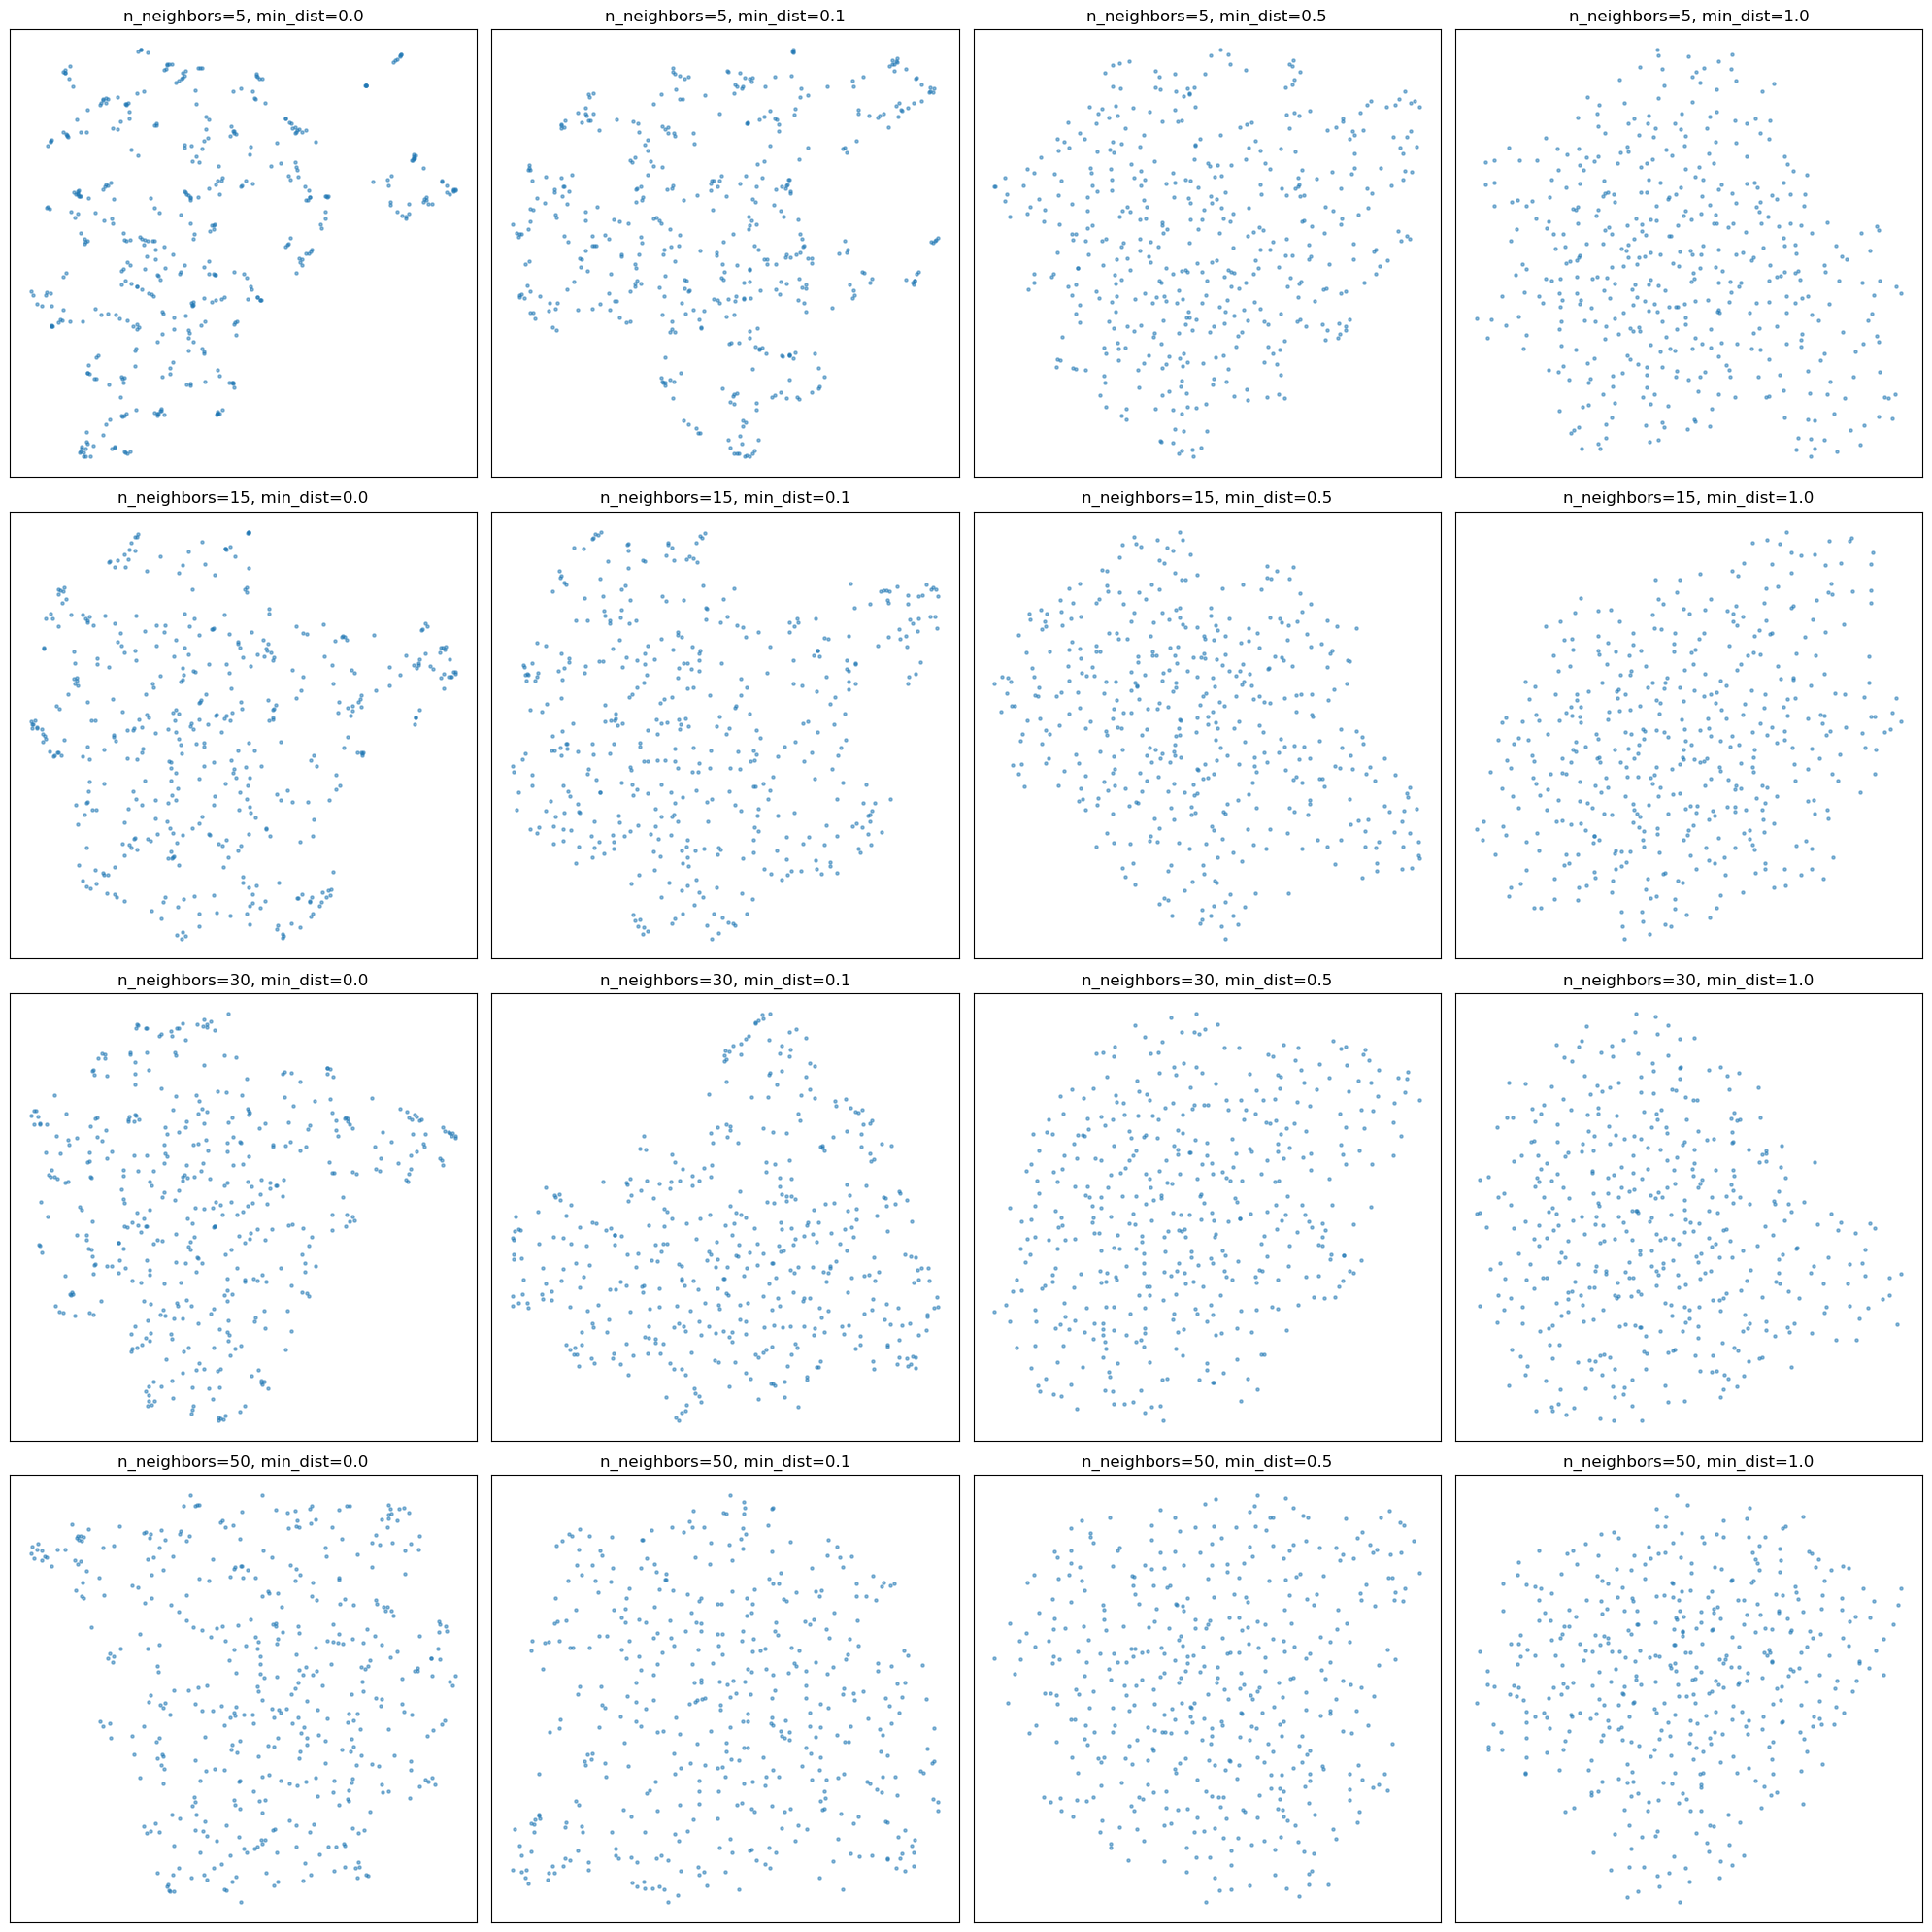

In [79]:
# 读取三个数据集
gene_expr = read_gene_expression(gene_expression_path)
somatic_mut = read_somatic_mutations(somatic_mutations_path)
patient_meta = read_patient_metadata(metadata_path)

# Select only the numeric columns for filling NaNs
gene_columns = gene_expr.columns[2:]  # 假设前两列非数值型
gene_expr_numeric = gene_expr[gene_columns]

# 用每个基因的均值填补缺失值
gene_expr_numeric_filled = gene_expr_numeric.fillna(gene_expr_numeric.mean())

# 将填补后的数值列替换回原始 DataFrame
gene_expr[gene_columns] = gene_expr_numeric_filled

# 现在你可以运行分析，例如使用PCA预降维再用UMAP参数优化
optimize_umap_parameters(gene_expr, pca=True)

In [134]:
umap_results = perform_umap_analysis(gene_expr, patient_meta, n_neighbors=15, min_dist=0.2)
print(umap_results.head())

Performing UMAP with n_neighbors=15, min_dist=0.2...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


       UMAP1     UMAP2    patient_id  type  \
0  11.824530 -0.665190  TCGA-CG-4460  STAD   
1  17.581348 -3.967913  TCGA-CG-5716  STAD   
2  16.195204 -0.027976  TCGA-HF-7131  STAD   
3  13.428829 -2.342216  TCGA-3M-AB46  STAD   
4  18.562996 -0.838571  TCGA-3M-AB47  STAD   

   age_at_initial_pathologic_diagnosis  gender             race  \
0                                 66.0  FEMALE  [Not Available]   
1                                 86.0    MALE  [Not Available]   
2                                  NaN  FEMALE  [Not Available]   
3                                 70.0    MALE            WHITE   
4                                 51.0    MALE            WHITE   

  ajcc_pathologic_tumor_stage  \
0                    Stage IV   
1                    Stage IV   
2                    Stage IB   
3                    Stage IB   
4                  Stage IIIB   

                                   histological_type histological_grade  ...  \
0  Stomach, Intestinal Adenocarcinoma, No

/var/folders/nc/97c66xss2gv6hnxxtwj3_phr0000gn/T/ipykernel_95080/739700376.py:92: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(categories))


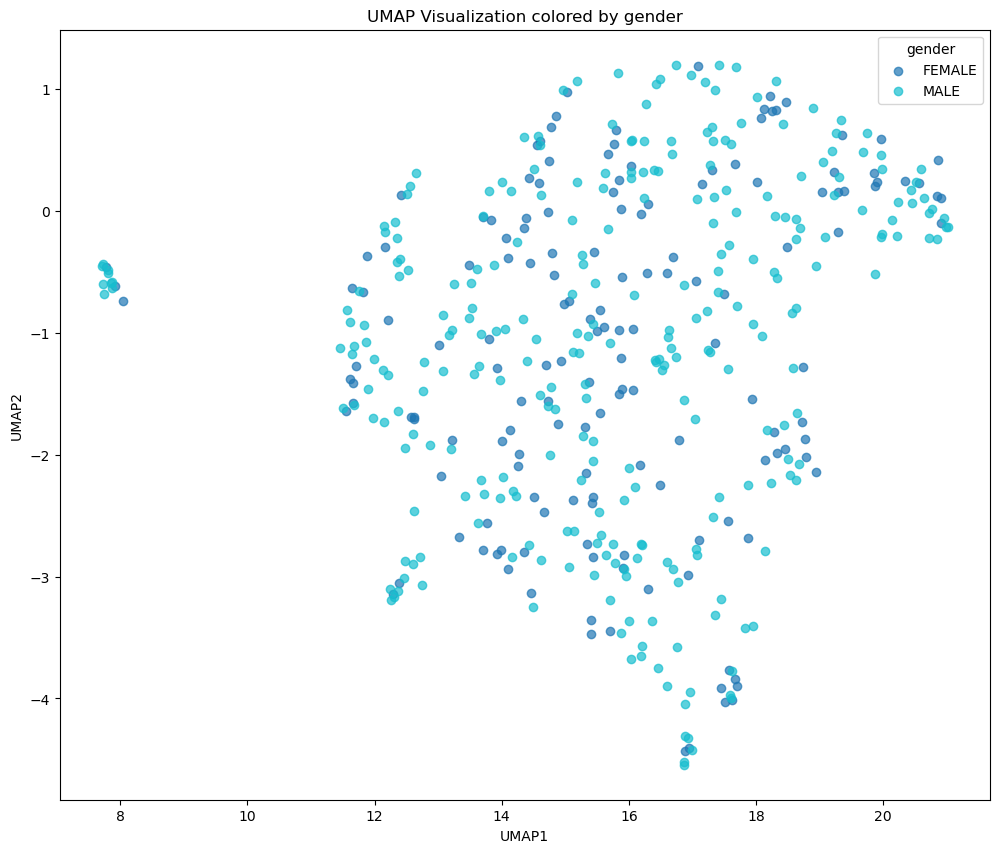

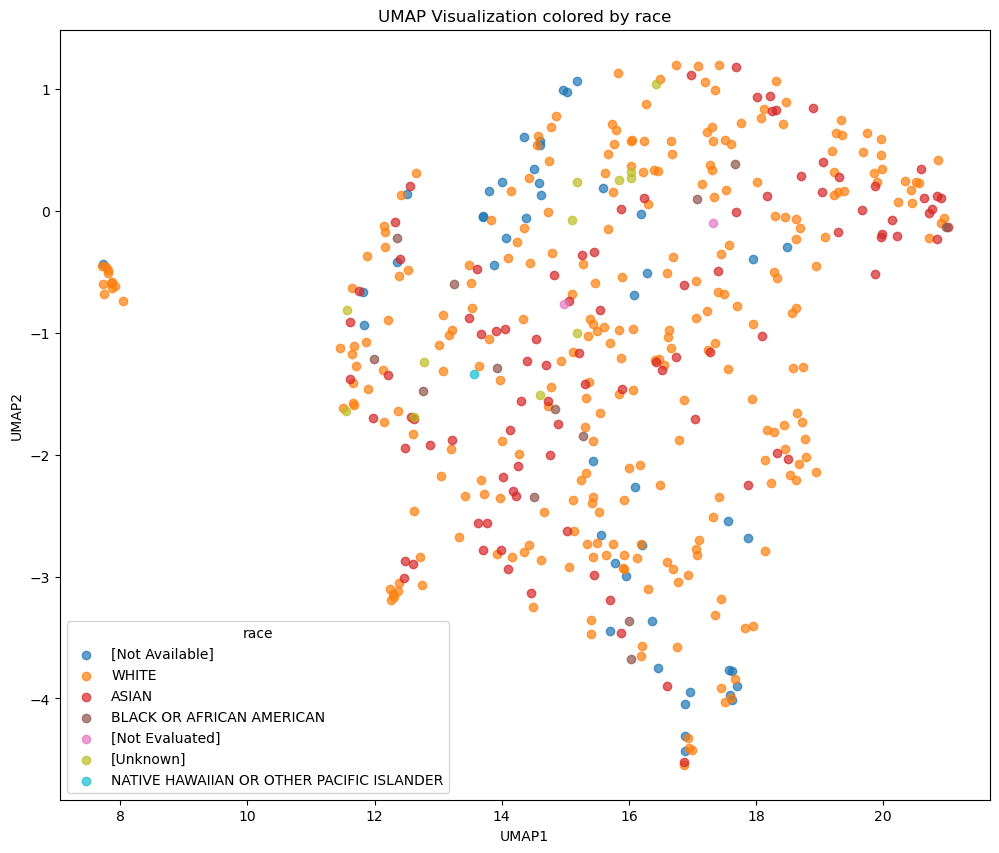

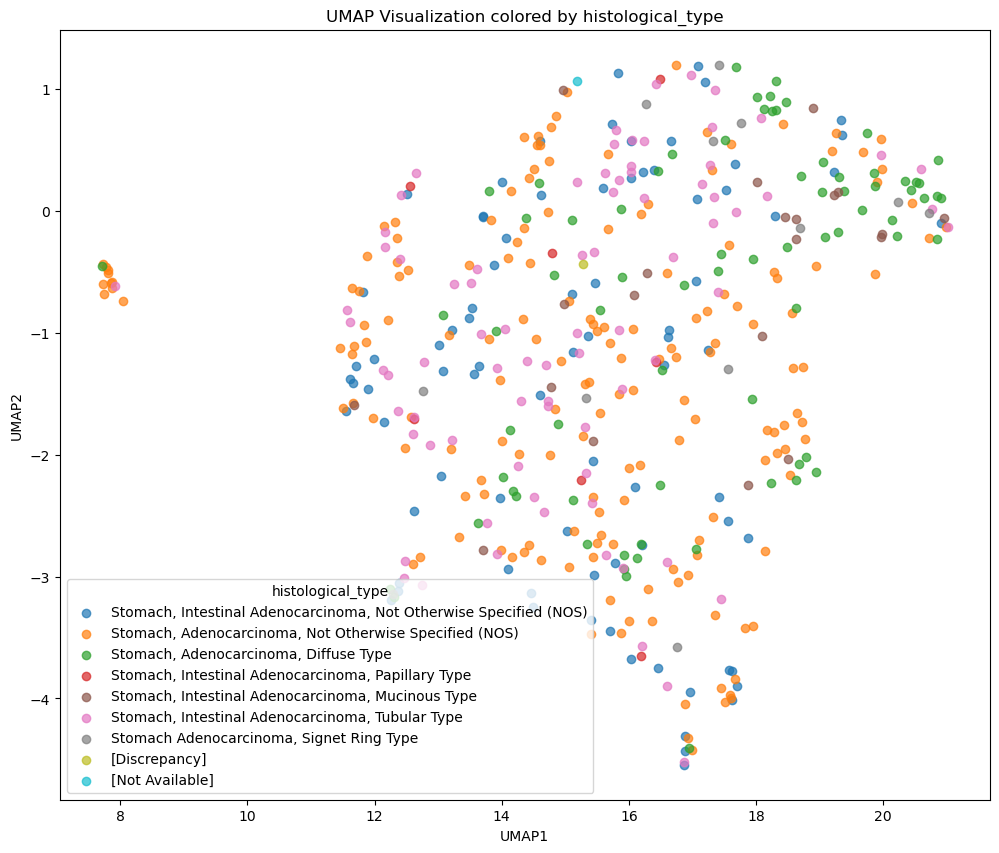

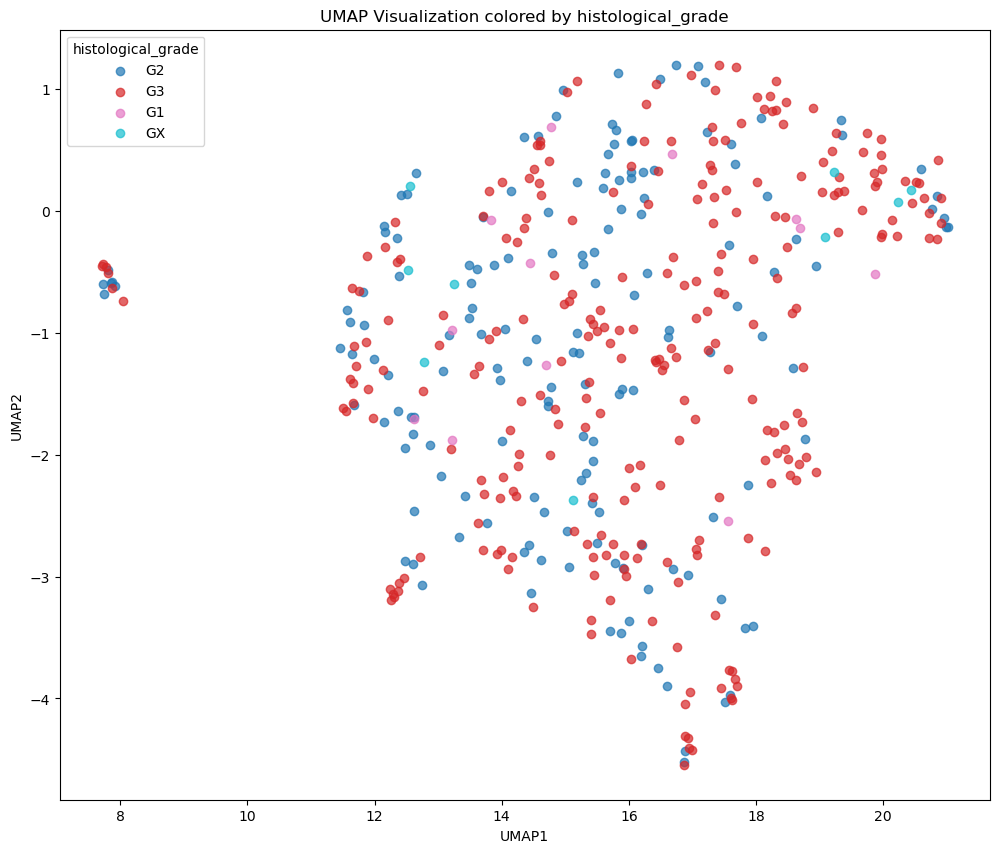

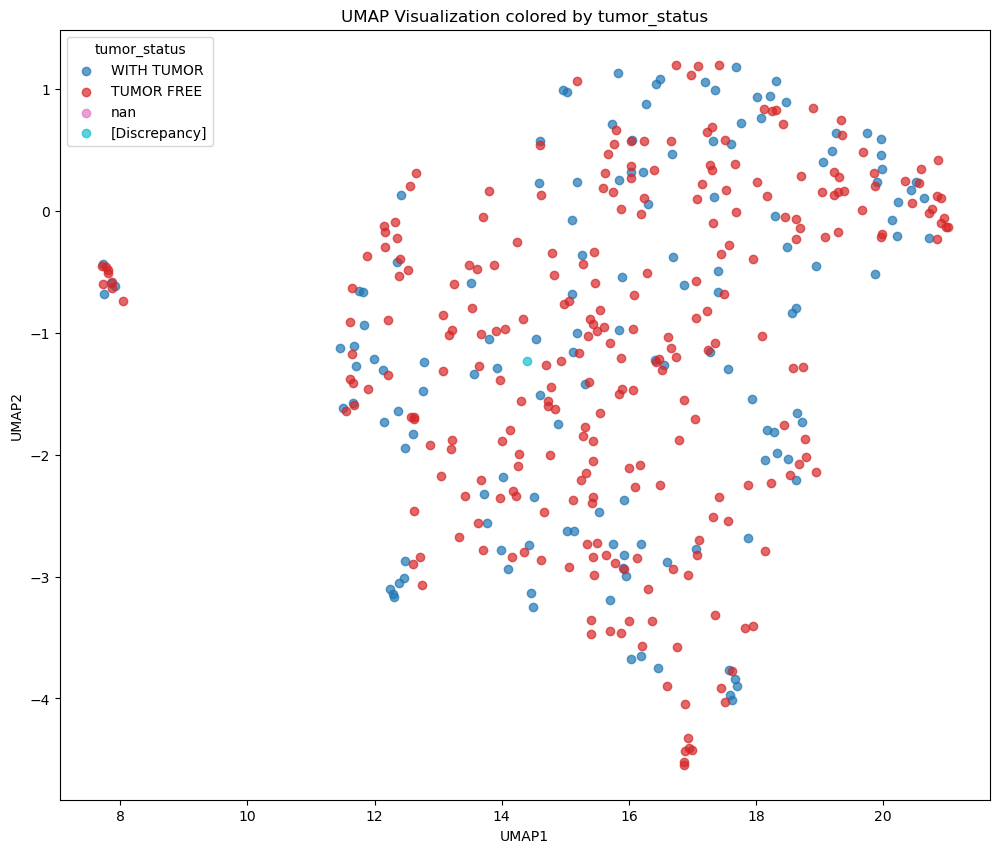

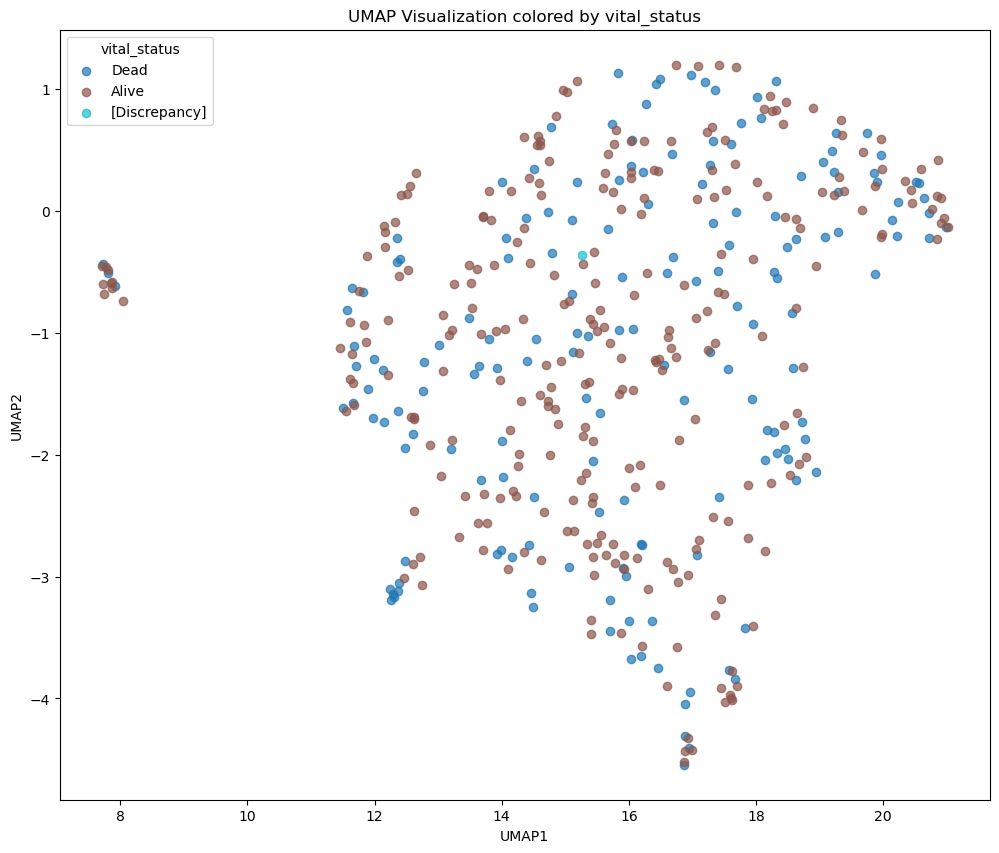

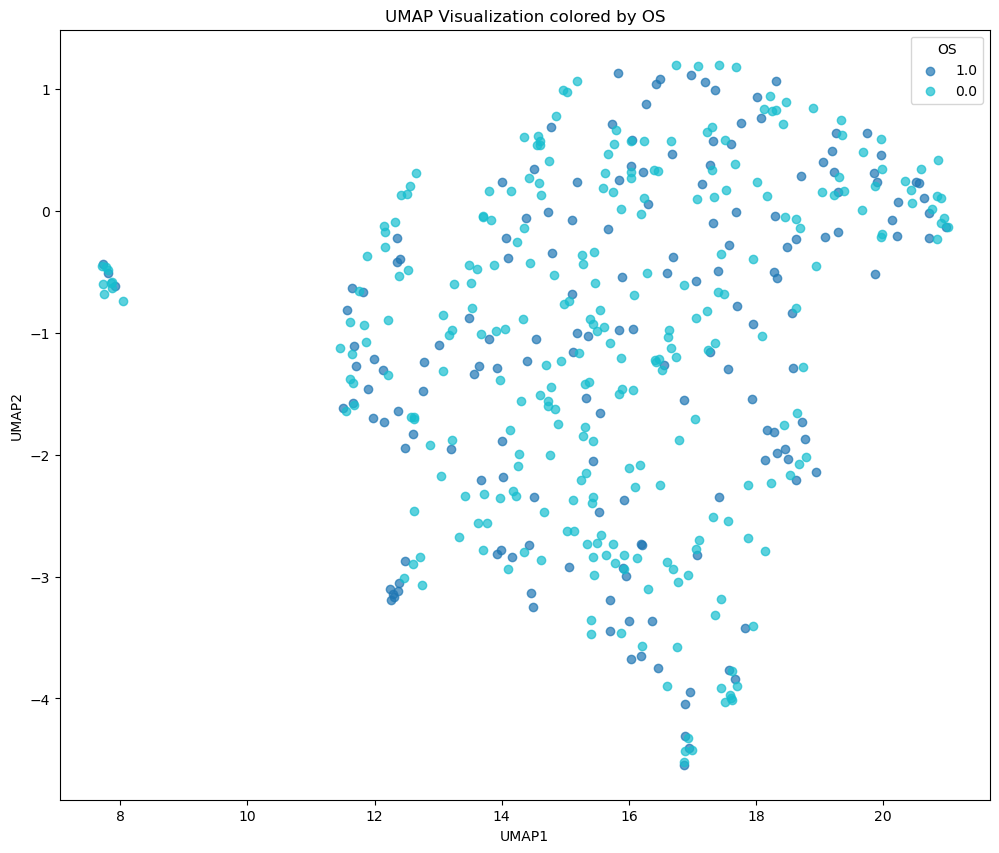

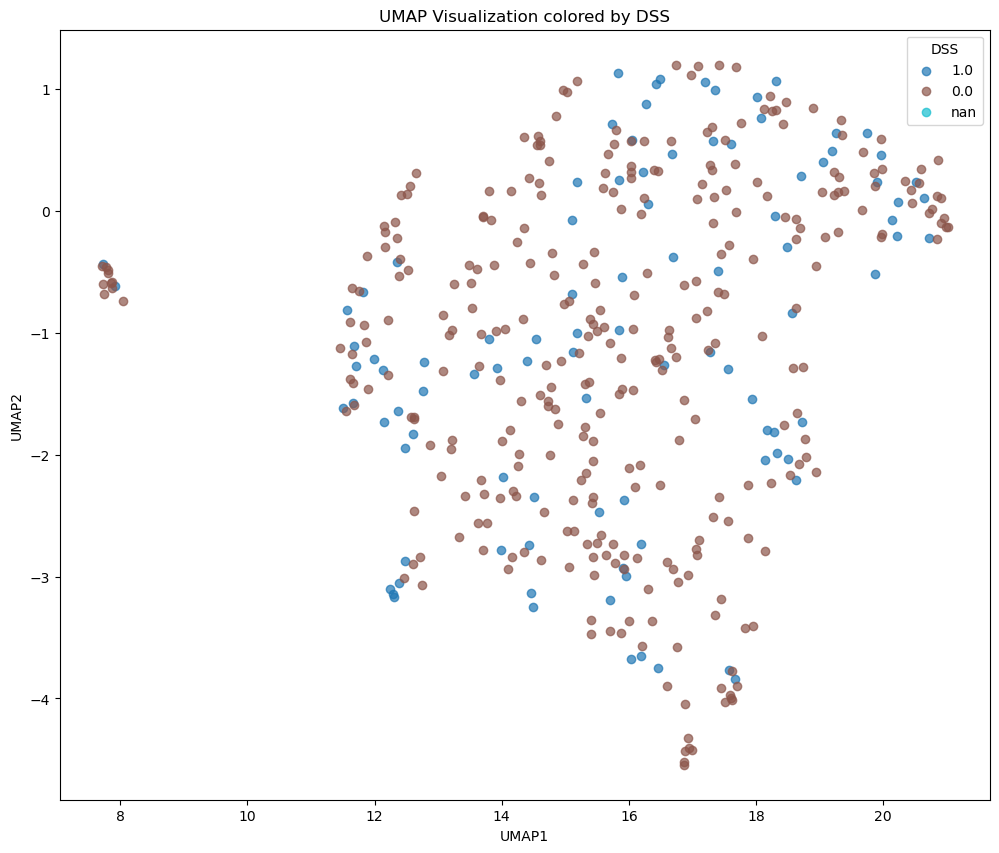

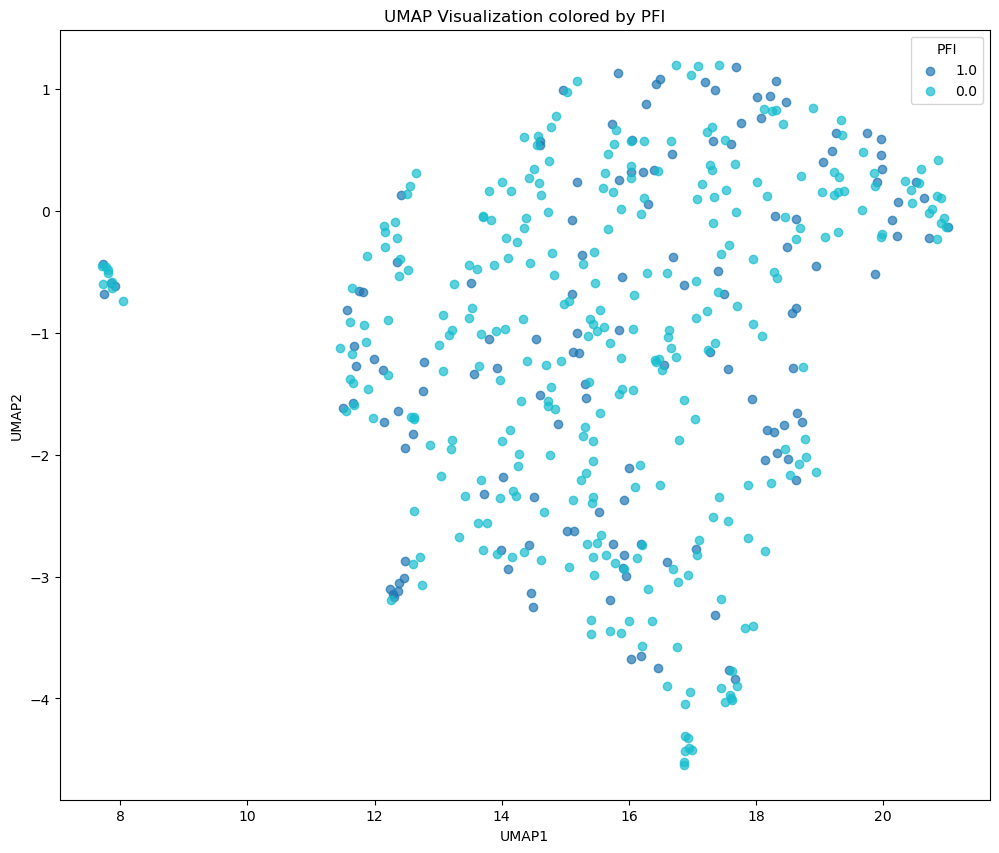

In [135]:
visualize_umap(umap_results, color_by='gender')
visualize_umap(umap_results, color_by='race')
visualize_umap(umap_results, color_by='histological_type')
visualize_umap(umap_results, color_by='histological_grade')
visualize_umap(umap_results, color_by='tumor_status')
visualize_umap(umap_results, color_by='vital_status')
visualize_umap(umap_results, color_by='OS')
visualize_umap(umap_results, color_by='DSS')
visualize_umap(umap_results, color_by='PFI')

Identified 8 clusters in UMAP results
Cluster distribution: -1     21
 0     51
 1    254
 2     20
 3     22
 4     55
 5     12
 6     12
Name: count, dtype: int64


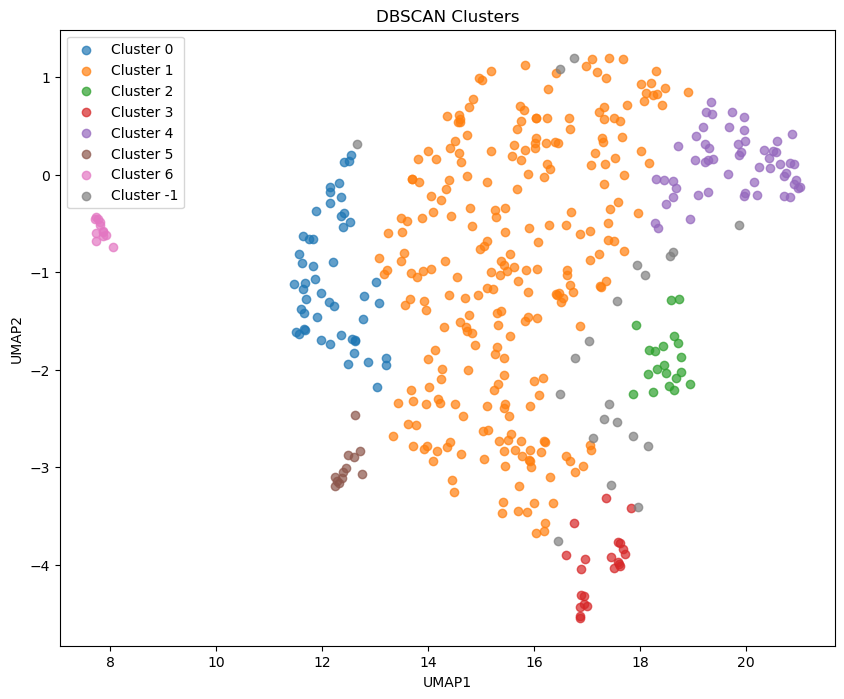


Analyzing differences in gender between clusters:
gender   FEMALE  MALE
cluster              
-1            5    16
 0           17    34
 1           97   157
 2           10    10
 3            8    14
 4           17    38
 5            2    10
 6            3     9
Chi-square test: chi2=6.94, p-value=0.4352

Analyzing differences in age_at_initial_pathologic_diagnosis between clusters:
ANOVA test: F=2.30, p-value=0.0259
         count       mean        std   min    25%   50%    75%   max
cluster                                                             
-1        21.0  60.809524   8.823939  43.0  54.00  62.0  67.00  74.0
 0        50.0  66.200000   9.674287  45.0  59.00  68.0  73.75  86.0
 1       250.0  67.028000  10.705777  30.0  60.00  69.0  74.00  90.0
 2        20.0  64.150000  11.160433  41.0  57.00  63.5  74.00  82.0
 3        22.0  66.045455  10.899879  46.0  58.00  64.5  70.50  88.0
 4        55.0  62.363636  10.323227  34.0  55.50  62.0  70.00  80.0
 5        12.0  62.

In [136]:
# Define the metadata columns you are interested in
# type	age_at_initial_pathologic_diagnosis	gender	race ajcc_pathologic_tumor_stage	histological_type	histological_grade	tumor_status	vital_status	OS	OS.time	DSS	DSS.time	DFI	DFI.time	PFI	PFI.time	Redaction
metadata_columns = ['gender',
                    'age_at_initial_pathologic_diagnosis',
                    'ajcc_pathologic_tumor_stage',
                    'histological_type',
                    'histological_grade',
                    'tumor_status',
                    'vital_status',
                    'OS', 'DSS', 'DFI','PFI']

# Analyze UMAP clusters with the specified number of clusters and metadata columns
analyze_umap_clusters(umap_results, n_clusters=10, metadata_columns=metadata_columns, clustering_method='dbscan')

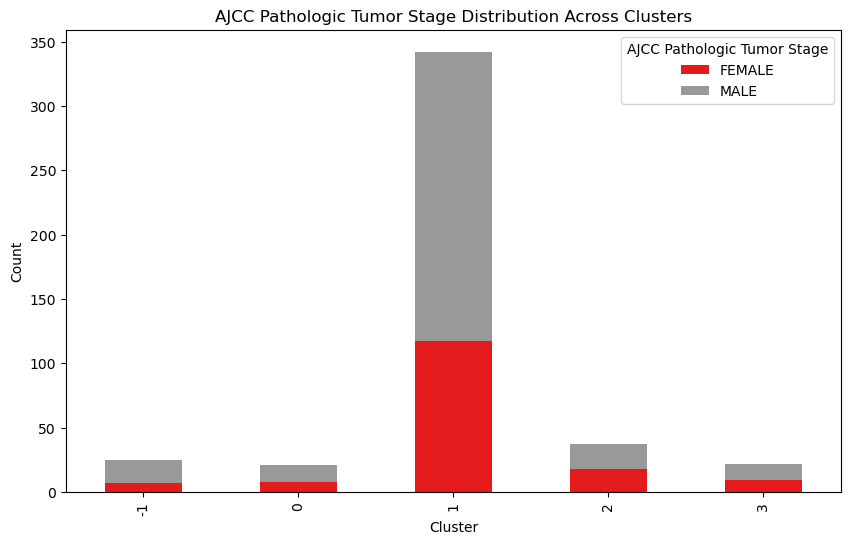

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# 计算每个簇中 ajcc_pathologic_tumor_stage 的分布
gender_distribution = pd.crosstab(umap_results['cluster'], umap_results['gender'])

# 绘制堆叠条形图
gender_distribution.plot(kind='bar', stacked=True, colormap='Set1', figsize=(10, 6))

# 图标题和标签
plt.title('AJCC Pathologic Tumor Stage Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='AJCC Pathologic Tumor Stage')

# 显示图表
plt.show()


/var/folders/nc/97c66xss2gv6hnxxtwj3_phr0000gn/T/ipykernel_95080/774166127.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=umap_results, x='cluster', y='age_at_initial_pathologic_diagnosis', palette='Set2')


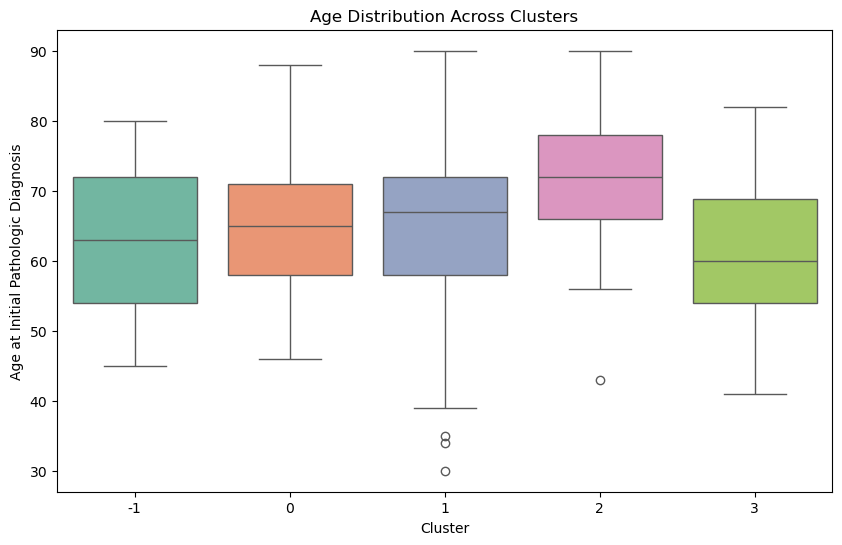

In [45]:
# 假设 'age_at_initial_pathologic_diagnosis' 是一个连续变量
plt.figure(figsize=(10, 6))

# 绘制箱线图
sns.boxplot(data=umap_results, x='cluster', y='age_at_initial_pathologic_diagnosis', palette='Set2')

# 图标题和标签
plt.title('Age Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Age at Initial Pathologic Diagnosis')

plt.show()
